In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import util.util_validation as ut_val
from util.util_logging import load_confusion_matrix, open_csv_file

pd.set_option('display.max_columns', None)
seaborn.set_style("darkgrid")

In [2]:
epoch = "last"

exclude_params_dict = {"tag": ["CropSize32", "divergent", "toSlow", "lrAdjust1", "lrAdjust2", "noCosine", "bszAdjust1"]}
keep_params_dict = {"aug": ["colorJitter", "grayscale"]}
models_dict, df_modelNames = ut_val.collect_models_dict(epoch=epoch, dataset_classifier="", exclude_params_dict=exclude_params_dict, keep_params_dict=keep_params_dict)
print(df_modelNames.to_markdown(index=False))

| model_name                                                                            |
|:--------------------------------------------------------------------------------------|
| CE_animals10_diff_-1+4000_allAug                                                      |
| CE_animals10_diff_-1+8000_allAug                                                      |
| CE_animals10_diff_-1+adaINtexture_allAug                                              |
| CE_animals10_diff_-1+stylized_allAug                                                  |
| CE_animals10_diff_-1_allAug                                                           |
| CE_animals10_diff_4000_allAug                                                         |
| CE_animals10_diff_adaINtexture_allAug                                                 |
| CE_animals10_diff_stylized_allAug                                                     |
| CE_city_classification_diff_allAug                                                    |
| CE_city_

## Table of Accuracies

In [3]:
acc_dict_val = {"model_name": []}
datasets_cm_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    acc_dict_val["model_name"].append(mn)

    cm_path_val = glob.glob(os.path.join(path_folder, f"val_{epoch}", "*", "cm", f"cm_val_epoch_{epoch}.csv"))
    datasets_cm_all = datasets_cm_all.union([cm_path.split('/')[-3] for cm_path in cm_path_val])
datasets_cm_all = sorted(datasets_cm_all)
for dset in datasets_cm_all:
    acc_dict_val[dset] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_cm_all:
        cm_dset_path_val = glob.glob(os.path.join(path_folder, f"val_{epoch}", dset, "cm", f"cm_val_epoch_{epoch}.csv"))
        if len(cm_dset_path_val) == 1:
            C_val = load_confusion_matrix(cm_dset_path_val[0])
            acc_val, acc_b_val = ut_val.compute_accuracies_form_cm(C_val)
            acc_dict_val[dset].append(f"{acc_val*100:.2f} ({acc_b_val*100:.2f})")
        else:
            acc_dict_val[dset].append("")

df_acc = pd.DataFrame.from_dict(acc_dict_val)

In [4]:
datasets_cm_select = ["animals10_diff_-1", "animals10_diff_4000", "animals10_diff_8000"]
df_acc.loc[(df_acc[datasets_cm_select].iloc[:,1:] == "").apply(lambda x: not x.all(), axis=1), ["model_name"]+datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

,model_name,animals10_diff_-1,animals10_diff_4000,animals10_diff_8000
0,CE_animals10_diff_-1+4000_allAug,94.75 (94.04),93.01 (92.18),90.85 (89.70)
1,CE_animals10_diff_-1+8000_allAug,94.08 (93.37),92.27 (91.16),90.60 (89.47)
2,CE_animals10_diff_-1+adaINtexture_allAug,93.35 (92.61),70.57 (68.92),61.55 (60.10)
3,CE_animals10_diff_-1+stylized_allAug,93.60 (92.79),79.66 (77.37),73.13 (70.31)
4,CE_animals10_diff_-1_allAug,94.92 (94.32),61.94 (60.00),51.28 (49.32)
5,CE_animals10_diff_4000_allAug,69.56 (65.98),92.02 (91.08),88.69 (87.40)
6,CE_animals10_diff_adaINtexture_allAug,72.56 (71.30),61.17 (57.42),54.74 (50.67)
7,CE_animals10_diff_stylized_allAug,84.22 (82.94),73.55 (70.90),66.71 (64.14)
11,SupConHybrid_animals10_diff_-1+4000_cAug,57.98 (51.17),57.81 (51.03),57.07 (50.13)
12,SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100,93.05 (92.50),92.21 (91.82),90.68 (90.14)


In [7]:
datasets_cm_select = ["animals10_diff_stylized", "animals10_diff_adaINtexture",
                      "animals10_diff_-1PatchSize30", "animals10_diff_-1PixelShuffled"]
df_acc.loc[(df_acc[datasets_cm_select] == "").apply(lambda x: not x.all(), axis=1), ["model_name"]+datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

,model_name,animals10_diff_stylized,animals10_diff_adaINtexture,animals10_diff_-1PatchSize30,animals10_diff_-1PixelShuffled
0,CE_animals10_diff_-1+4000_allAug,40.16 (38.87),,30.58 (28.05),18.41 (10.00)
1,CE_animals10_diff_-1+8000_allAug,40.79 (39.11),,26.34 (22.01),17.76 (12.16)
2,CE_animals10_diff_-1+adaINtexture_allAug,63.27 (60.81),73.36 (70.41),21.47 (22.49),14.17 (10.17)
3,CE_animals10_diff_-1+stylized_allAug,80.92 (78.44),,20.21 (16.75),18.01 (9.82)
4,CE_animals10_diff_-1_allAug,40.16 (36.36),,35.22 (31.48),18.68 (10.56)
5,CE_animals10_diff_4000_allAug,31.67 (30.06),,20.03 (20.24),13.62 (10.68)
6,CE_animals10_diff_adaINtexture_allAug,60.62 (56.88),68.12 (65.15),11.46 (11.44),14.78 (9.79)
7,CE_animals10_diff_stylized_allAug,77.65 (74.86),,14.61 (11.78),8.38 (10.13)
11,SupConHybrid_animals10_diff_-1+4000_cAug,24.56 (19.13),,7.87 (10.48),15.36 (11.27)
12,SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100,39.69 (39.99),,19.60 (16.16),18.01 (10.33)


In [4]:
datasets_cm_select = ["city_classification_original", "city_classification_diff",
                      "stylized_city_classification", "stylized_city_classification_304x304", "city_classification_originalPatchSize30",
                      "city_classification_originalPixelShuffled"]
df_acc.loc[(df_acc[datasets_cm_select] == "").apply(lambda x: not x.all(), axis=1), ["model_name"]+datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

,model_name,city_classification_original,city_classification_diff,stylized_city_classification,stylized_city_classification_304x304,city_classification_originalPatchSize30,city_classification_originalPixelShuffled
6,CE_city_classification_diff_allAug,83.50 (71.62),81.60 (71.38),17.80 (14.15),,25.01 (10.96),13.02 (8.21)
7,CE_city_classification_original+diff_allAug,92.03 (86.55),82.69 (73.35),22.74 (17.11),,24.99 (13.13),4.62 (9.06)
8,CE_city_classification_original_allAug,91.25 (84.96),56.52 (50.95),28.43 (16.72),28.99 (17.43),23.80 (10.16),7.42 (7.68)
18,SupCon_city_classification_original+diff_cAugSameSAug,90.73 (85.39),82.34 (72.87),23.73 (21.45),23.92 (21.36),19.18 (14.05),4.60 (9.09)
19,SupCon_city_classification_original_allAug,91.58 (86.56),58.51 (49.58),21.67 (19.91),21.55 (20.29),21.74 (11.02),4.60 (9.09)


-------------

### Latex tables

In [99]:
df_acc_latex = df_acc.copy()

dataset_dict = {"animals10_diff_-1": "orig",
                "animals10_diff_4000": "diff4000",
                "animals10_diff_8000": "diff8000",
                "animals10_diff_stylized": "stylized",
                "animals10_diff_adaINtexture": "adaINtexture",
                "animals10_diff_-1PatchSize30": "patches30",
                "animals10_diff_-1PixelShuffled": "pixels",
                "animals10_diff_-1+4000": "orig+diff4000",
                "animals10_diff_-1+8000": "orig+diff8000",
                "animals10_diff_-1+stylized": "orig+stylized",
                "animals10_diff_-1+adaINtexture": "orig+adaINtexture",
                "city_classification_original": "cityOrig",
                "city_classification_diff": "cityDiff",
                "stylized_city_classification": "cityStylized",
                "city_classification_originalPatchSize30": "cityPatches30",
                "city_classification_originalPixelShuffled" : "cityPixels",
                "city_classification_original+diff": "cityOrig+Diff"}

other_dict = {"factor5cAugSameSAug": "",
              "fineTuneCAsameSAFactor5": "ft",
              "fineTuneCAsameSAFactor100": "ft",
              "fineTuneCAsameSAFactor100NoNormalize": "ft+noLossNorm."}

new_index = {"method": [], "trainDataset": [], "augmentations": [], "other": []}
for mn in df_acc_latex["model_name"]:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    mn_split = mn.split("_")

    new_index["method"].append((params["method"] if "method" in params else "CE")\
                        + (f"_{params['related_factor']}" if "related_factor" in params and params['related_factor'] != 1.0 else ""))
    new_index["trainDataset"].append(dataset_dict[params['dataset']])
    if mn_split[-1] == params["tag"]:
        new_index["augmentations"].append(mn_split[-2])
        
        new_index["other"].append(other_dict[params["tag"]])
    else:
        new_index["augmentations"].append(mn_split[-1])
        new_index["other"].append("")

df_acc_latex.index = pd.MultiIndex.from_frame(pd.DataFrame.from_dict(new_index))

df_acc_latex.columns = [(dataset_dict[dset] if dset in dataset_dict else dset) for dset in df_acc_latex.columns]

In [100]:
datasets_cm_select = ["orig", "diff4000", "diff8000"]
index_select = np.arange(len(df_acc_latex))[(df_acc_latex[datasets_cm_select] == "").apply(lambda x: not x.all(), axis=1)]
df_acc_latex.iloc[index_select][datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc_latex[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0]))
)

In [101]:
datasets_cm_select = ["orig", "diff4000", "diff8000"]
index_select = np.arange(len(df_acc_latex))[(df_acc_latex[datasets_cm_select] == "").apply(lambda x: not x.all(), axis=1)]
print(df_acc_latex.iloc[index_select][datasets_cm_select].style.background_gradient(
    subset=datasets_cm_select, axis=None, gmap=df_acc_latex[datasets_cm_select].map(lambda x: np.nan if x == '' else float(x.split(' ')[0]))
).to_latex(
    caption="Classification Accuracies on animals10 original and diffused",
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True
).replace("_", "\_"))

\begin{table}
\centering
\caption{Classification Accuracies on animals10 original and diffused}
\begin{tabular}{lllllll}
\toprule
 &  &  &  & orig & diff4000 & diff8000 \\
method & trainDataset & augmentations & other &  &  &  \\
\midrule
\multirow[c]{8}{*}{CE} & orig+diff4000 & allAug &  & {\cellcolor[HTML]{02395A}} \color[HTML]{F1F1F1} 94.75 (94.04) & {\cellcolor[HTML]{03446A}} \color[HTML]{F1F1F1} 93.01 (92.18) & {\cellcolor[HTML]{045280}} \color[HTML]{F1F1F1} 90.85 (89.70) \\
\cline{2-7} \cline{3-7}
 & orig+diff8000 & allAug &  & {\cellcolor[HTML]{023D60}} \color[HTML]{F1F1F1} 94.08 (93.37) & {\cellcolor[HTML]{034871}} \color[HTML]{F1F1F1} 92.27 (91.16) & {\cellcolor[HTML]{045382}} \color[HTML]{F1F1F1} 90.60 (89.47) \\
\cline{2-7} \cline{3-7}
 & orig+adaINtexture & allAug &  & {\cellcolor[HTML]{034267}} \color[HTML]{F1F1F1} 93.35 (92.61) & {\cellcolor[HTML]{89B1D4}} \color[HTML]{000000} 70.57 (68.92) & {\cellcolor[HTML]{D2D2E7}} \color[HTML]{000000} 61.55 (60.10) \\
\cline{2-7} \cl

In [102]:
def mark_two_highest(x):
    val_array = [(float(val.split(" ")[0]) if val != "" else 0.0) for val in x]
    idx_second, idx_max = np.argsort(val_array)[-2:]

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_max] = "font-weight: bold"

    return markers

In [103]:
# caption = "Classification Accuracies on animals10 original and diffused"
# datasets_cm_select = ["orig", "diff4000", "diff8000"]

# caption = "Classification Accuracies on animals10 stylized with paintings or textures and patches or pixel shuffled"
# datasets_cm_select = ["stylized", "adaINtexture", "patches30", "pixels"]

# caption = "Classification Accuracies on cityscapes original and diffused"
# datasets_cm_select = ["cityOrig", "cityDiff"]

caption = "Classification Accuracies on cityscapes stylized with paintings or textures and patches or pixel shuffled"
datasets_cm_select = ["cityStylized", "cityPatches30", "cityPixels"]


index_select = np.arange(len(df_acc_latex))[(df_acc_latex[datasets_cm_select] == "").apply(lambda x: not x.all(), axis=1)]
df_acc_latex.iloc[index_select][datasets_cm_select].style.apply(mark_two_highest, axis=0, subset=datasets_cm_select)

In [104]:
print(df_acc_latex.iloc[index_select][datasets_cm_select].style.apply(mark_two_highest, axis=0, subset=datasets_cm_select
).to_latex(
    caption=caption,
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True
).replace("_", "\_"))

\begin{table}
\centering
\caption{Classification Accuracies on cityscapes stylized with paintings or textures and patches or pixel shuffled}
\begin{tabular}{lllllll}
\toprule
 &  &  &  & cityStylized & cityPatches30 & cityPixels \\
method & trainDataset & augmentations & other &  &  &  \\
\midrule
\multirow[c]{3}{*}{CE} & cityDiff & allAug &  & 17.80 (14.15) & \bfseries 25.01 (10.96) & \bfseries 13.02 (8.21) \\
\cline{2-7} \cline{3-7}
 & cityOrig+Diff & allAug &  & 22.74 (17.11) & \itshape 24.99 (13.13) & 4.62 (9.06) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & \bfseries 28.43 (16.72) & 23.80 (10.16) & \itshape 7.42 (7.68) \\
\cline{1-7} \cline{2-7} \cline{3-7}
\multirow[c]{2}{*}{SupCon} & cityOrig+Diff & cAugSameSAug &  & \itshape 23.73 (21.45) & 19.18 (14.05) & 4.60 (9.09) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & 21.67 (19.91) & 21.74 (11.02) & 4.60 (9.09) \\
\cline{1-7} \cline{2-7} \cline{3-7}
\bottomrule
\end{tabular}
\end{table}



## Table of Cue Conflict Shape Bias Metric

In [3]:
bias_dict = {"model_name": []}
datasets_bias_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    bias_dict["model_name"].append(mn)

    cue_conf_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", "*", "shape_bias.csv"))
    datasets_bias_all = datasets_bias_all.union([cue_conf_path.split('/')[-2] for cue_conf_path in cue_conf_paths])
datasets_bias_all = sorted(datasets_bias_all)
dset_cue_conf_plot_info_dict = dict()
for dset in datasets_bias_all:
    bias_dict[f"{dset}_sb"] = []
    bias_dict[f"{dset}_acc"] = []
    bias_dict[f"{dset}_acc_s"] = []
    bias_dict[f"{dset}_acc_t"] = []

    dset_cue_conf_plot_info_dict[dset] = [[], dict()]

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_bias_all:
        cue_conf_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", dset, "shape_bias.csv"))
        class_cue_conf_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CueConflict", dset, "classes_shape_bias.csv"))

        if len(cue_conf_dset_paths) == 1:
            df_bias = pd.read_csv(cue_conf_dset_paths[0], index_col=0)
            shape_bias, acc, acc_shape, acc_texture = df_bias.loc[["shape_bias", "acc", "acc_shape", "acc_texture"]].values[:,0]
            bias_dict[f"{dset}_sb"].append(shape_bias)
            bias_dict[f"{dset}_acc"].append(acc)
            bias_dict[f"{dset}_acc_s"].append(acc_shape)
            bias_dict[f"{dset}_acc_t"].append(acc_texture)

            if len(class_cue_conf_dset_paths) == 1:
                df_bias.columns = [mn]
                df_class_bias = pd.read_csv(class_cue_conf_dset_paths[0], index_col=0)
                dset_cue_conf_plot_info_dict[dset][0].append(df_bias)
                dset_cue_conf_plot_info_dict[dset][1][mn] = df_class_bias
        else:
            bias_dict[f"{dset}_sb"].append("")
            bias_dict[f"{dset}_acc"].append("")
            bias_dict[f"{dset}_acc_s"].append("")
            bias_dict[f"{dset}_acc_t"].append("")

df_bias = pd.DataFrame.from_dict(bias_dict)
multiIndex_tuples = [("", "model_name")]
for dset in datasets_bias_all:
    multiIndex_tuples.extend([(dset, "shape_bias"), (dset, "acc"), (dset, "acc_shape"), (dset, "acc_texture")])

    dset_cue_conf_plot_info_dict[dset][0] = pd.concat(dset_cue_conf_plot_info_dict[dset][0], axis=1)
df_bias.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

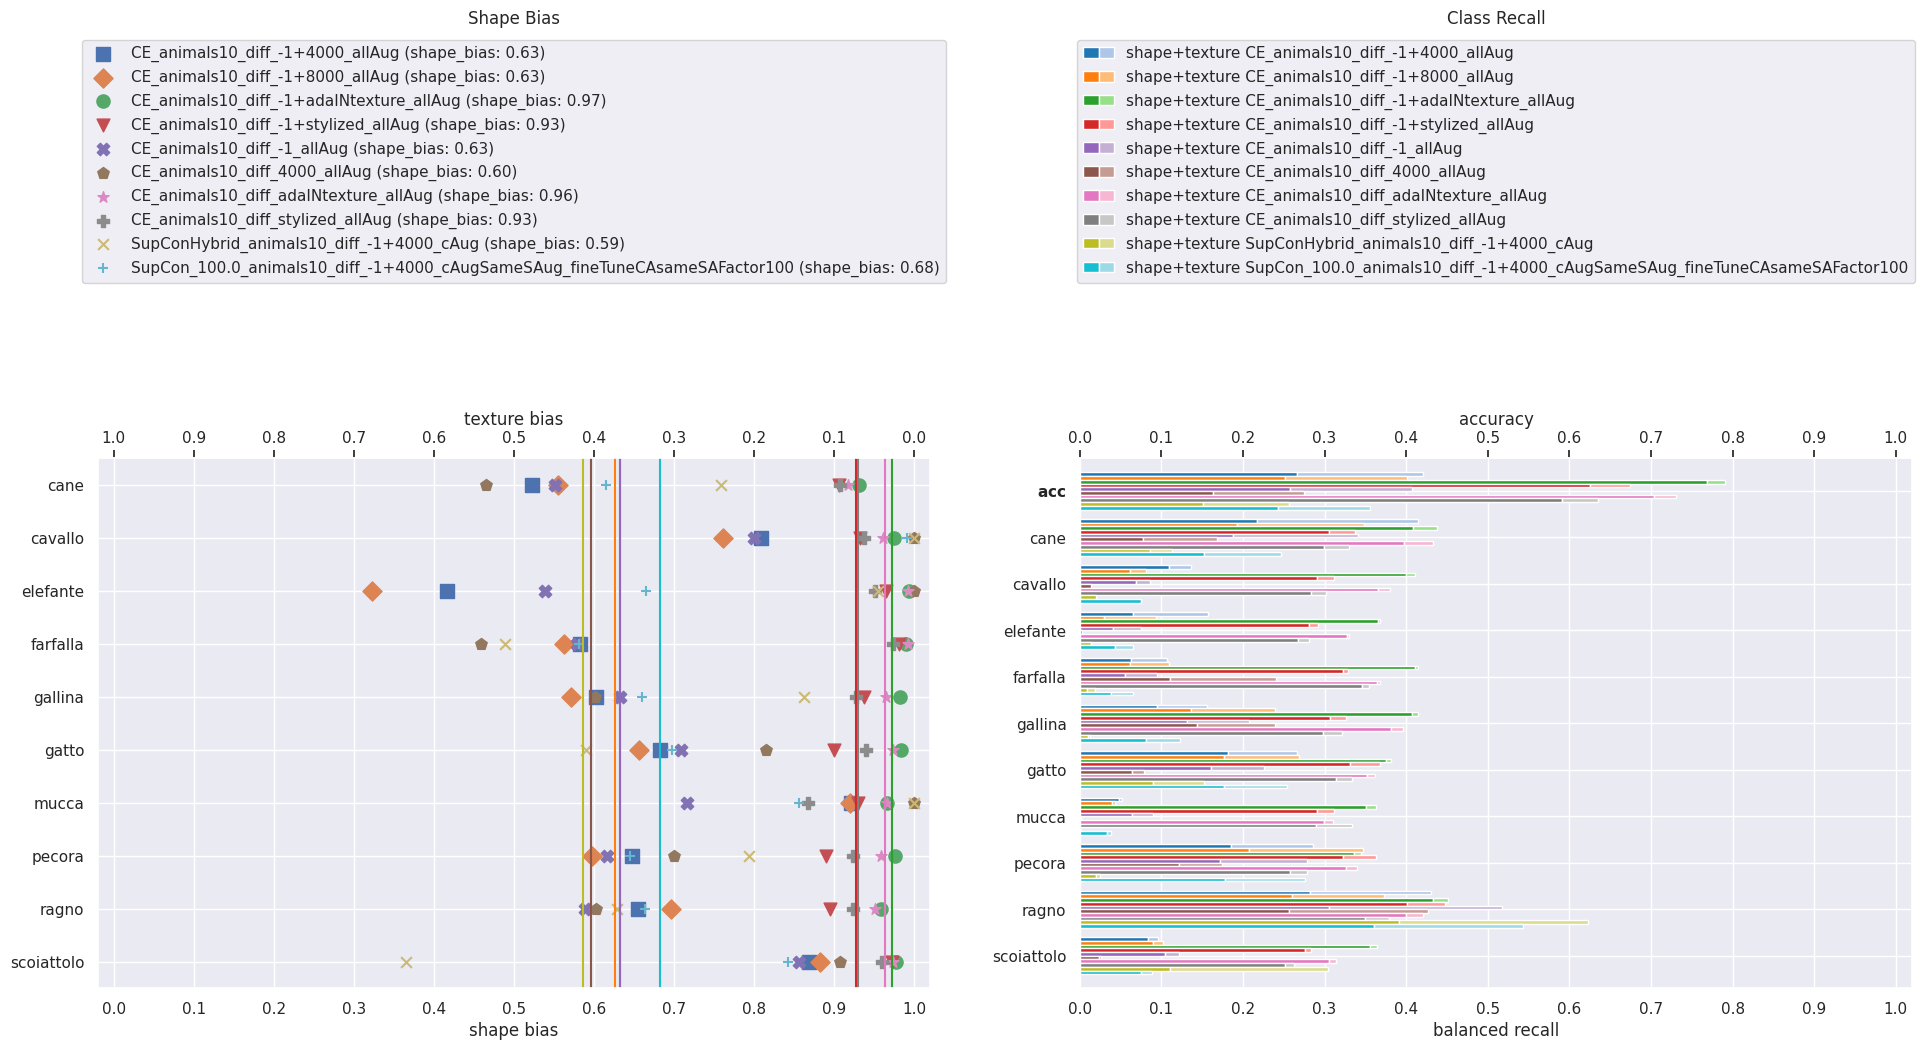

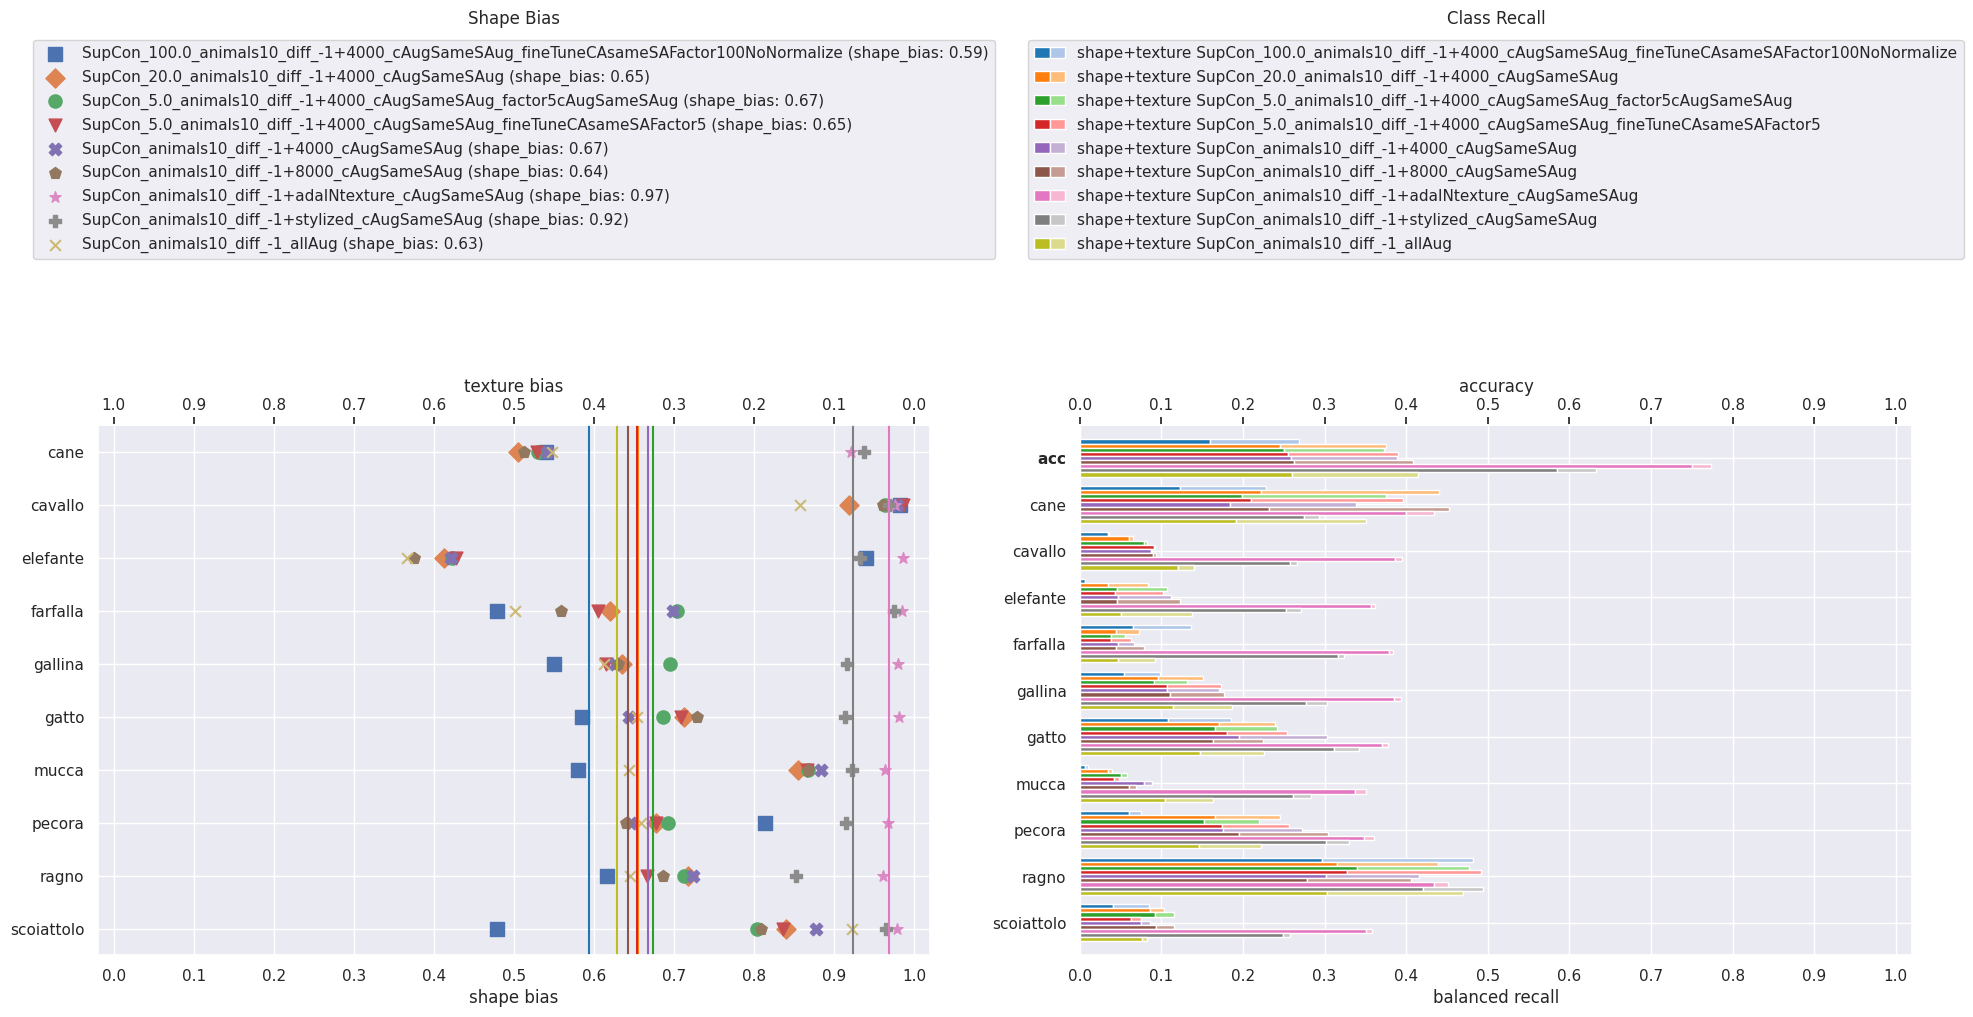

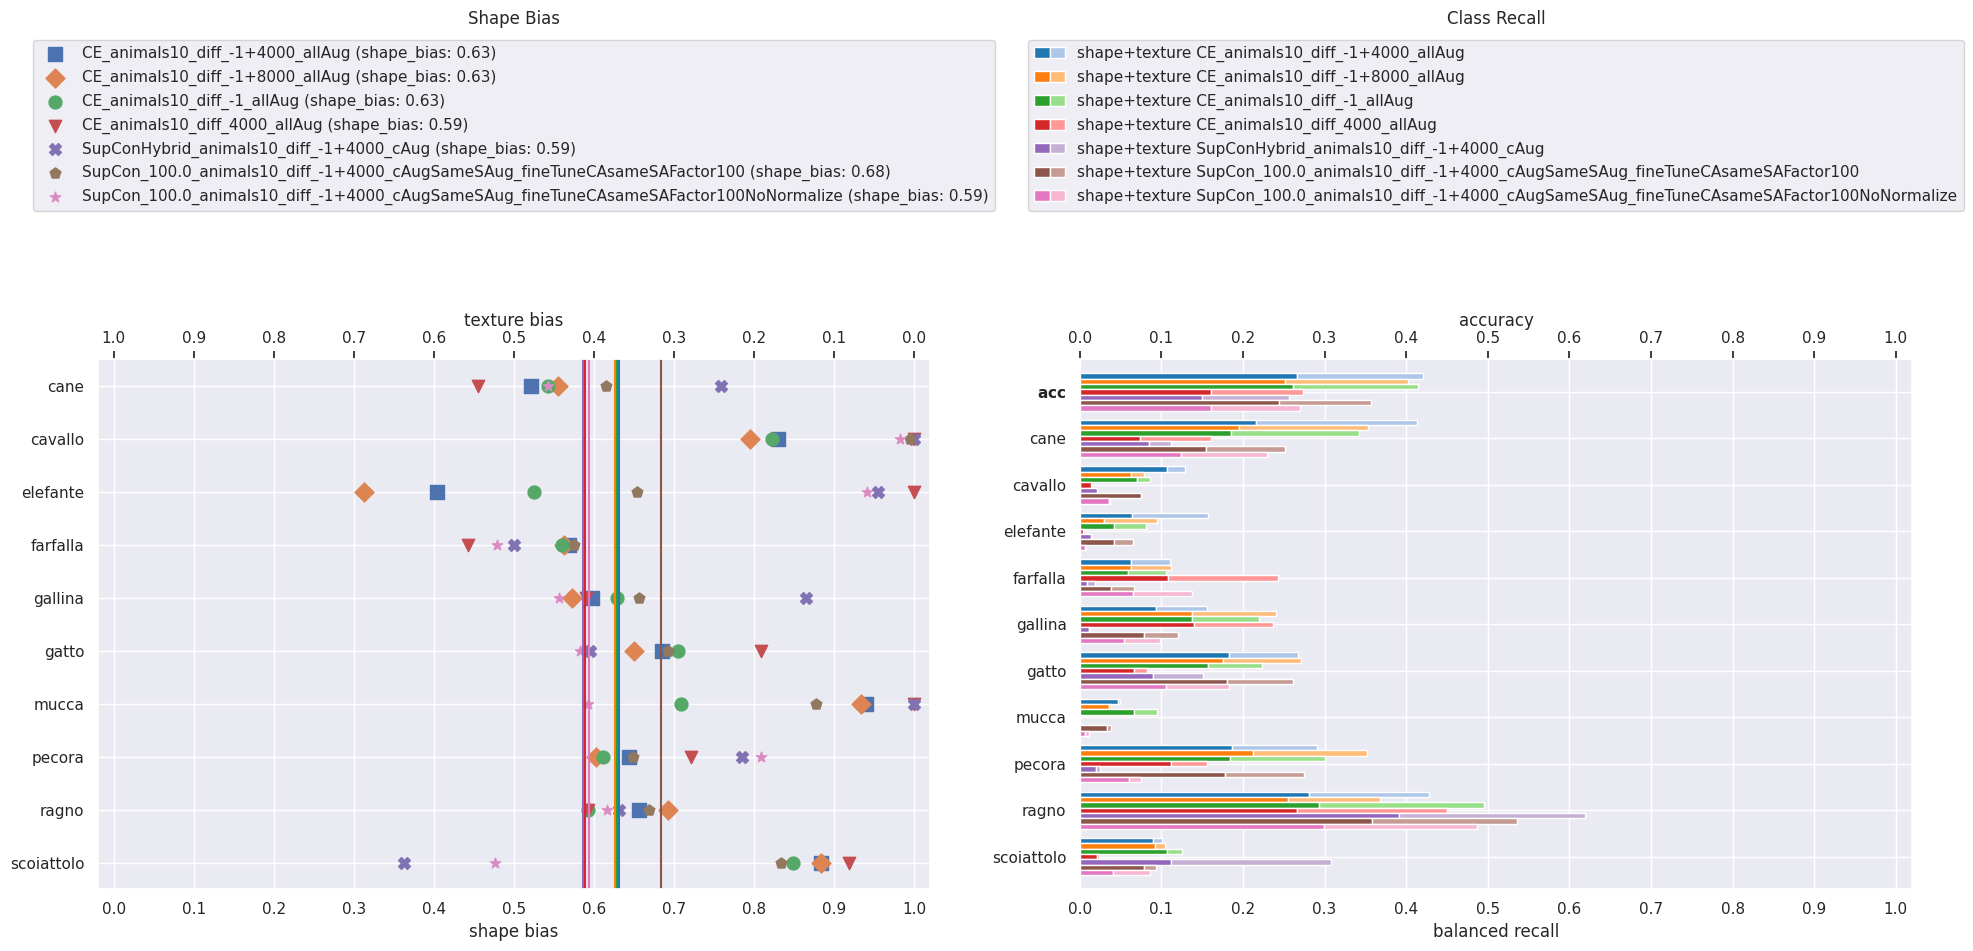

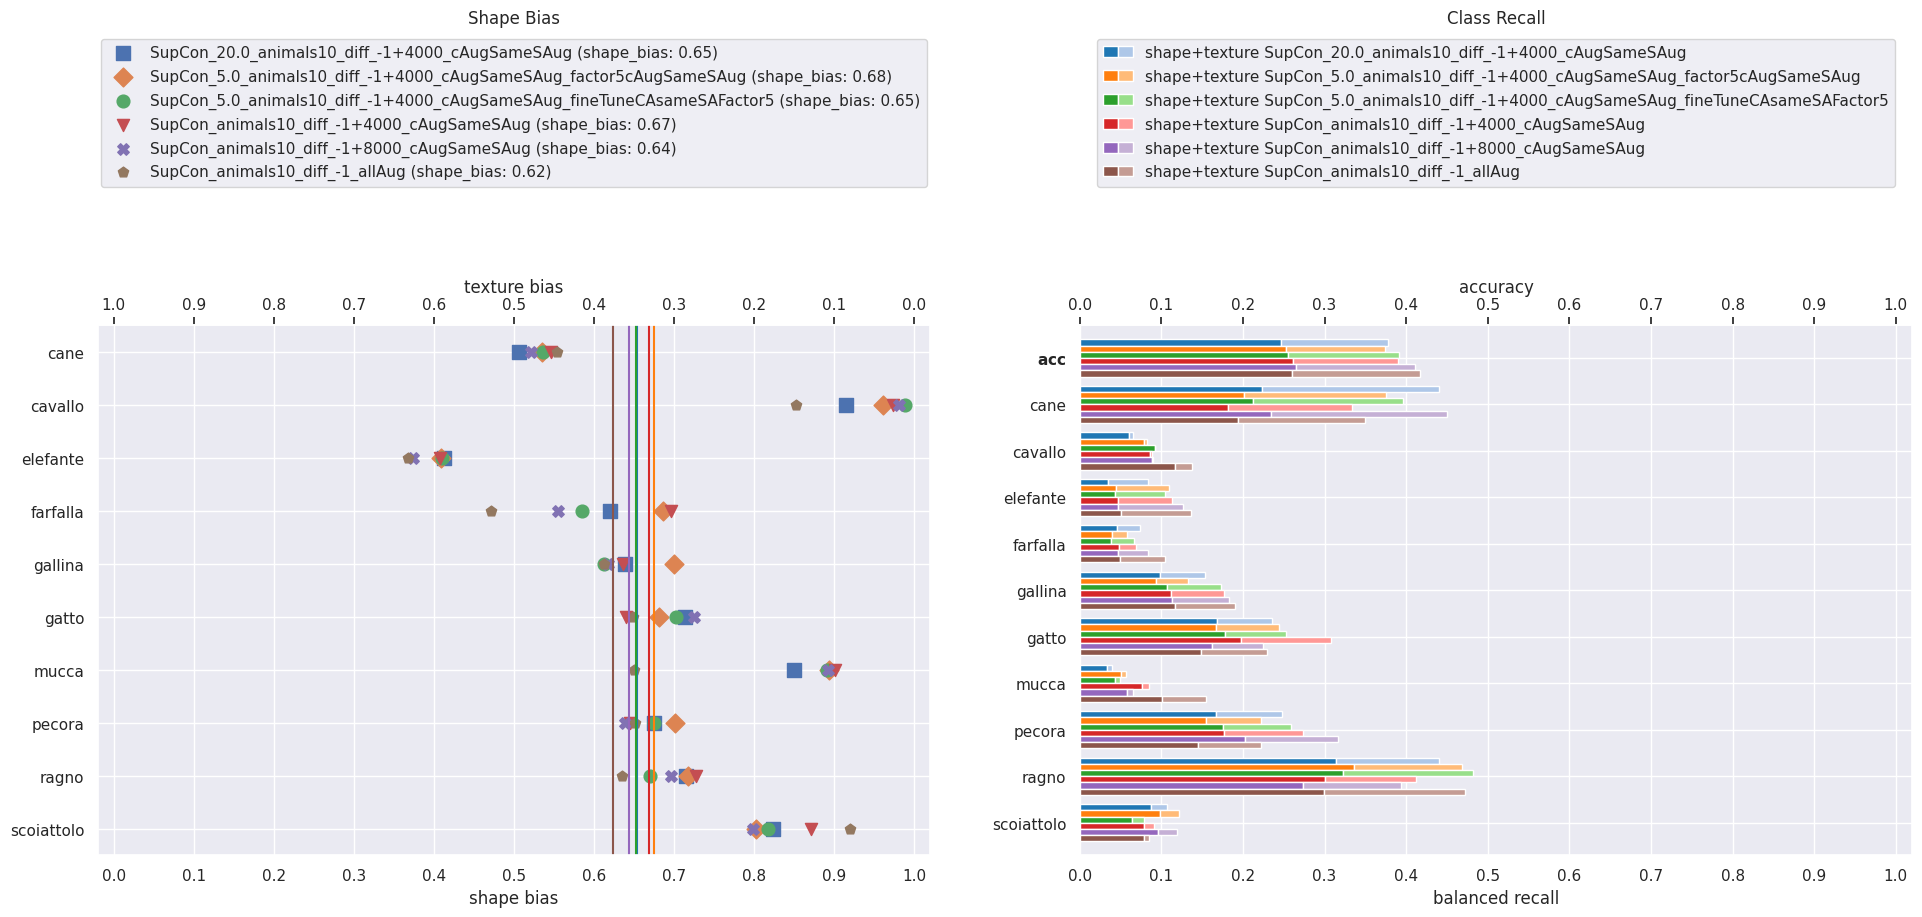

In [4]:
datasets_bias_selected = ["shape_texture_conflict_animals10_many", "shape_texture_conflict_animals10_many_304x304"]

for dset in datasets_bias_selected:
    df_biases, class_biasses = dset_cue_conf_plot_info_dict[dset]
    num_models = len(df_biases.columns)

    if num_models <= 10:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        fig.tight_layout(w_pad=3)

        ut_val.plot_shape_texture_conflict_bias(class_biasses, df_biases, ax=axs[0])
        ut_val.plot_class_recall_stacked(class_biasses, df_biases, ax=axs[1])
    else:
        num_splits = (num_models-1) // 10 + 1
        size_splits = [num_models // num_splits + (1 if i < num_models % num_splits else 0)  for i in range(num_splits)]
        model_names = list(df_biases.columns)
        for i in range(num_splits):
            start = sum(size_splits[:i])
            stop = sum(size_splits[:i+1])
            class_biasses_split = dict()
            for mn in model_names[start:stop]:
                class_biasses_split[mn] = class_biasses[mn]

            fig, axs = plt.subplots(ncols=2, figsize=(19, 6))
            fig.tight_layout(w_pad=6)

            ut_val.plot_shape_texture_conflict_bias(class_biasses_split, df_biases[model_names[start:stop]], ax=axs[0])
            ut_val.plot_class_recall_stacked(class_biasses_split, df_biases[model_names[start:stop]], ax=axs[1])


df_bias.loc[(df_bias[datasets_bias_selected] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_bias_selected].style.background_gradient(
    subset=datasets_bias_selected, axis=None, gmap=df_bias[datasets_bias_selected].map(lambda x: np.nan if x == '' else x))

------------------------
### Latex Tables

In [12]:
df_bias_latex = df_bias.copy()

dataset_dict = {"animals10_diff_-1": "orig",
                "animals10_diff_4000": "diff4000",
                "animals10_diff_8000": "diff8000",
                "animals10_diff_stylized": "stylized",
                "animals10_diff_adaINtexture": "adaINtexture",
                "animals10_diff_-1PatchSize30": "patches30",
                "animals10_diff_-1PixelShuffled": "pixels",
                "animals10_diff_-1+4000": "orig+diff4000",
                "animals10_diff_-1+8000": "orig+diff8000",
                "animals10_diff_-1+stylized": "orig+stylized",
                "animals10_diff_-1+adaINtexture": "orig+adaINtexture",
                "city_classification_original": "cityOrig",
                "city_classification_diff": "cityDiff",
                "stylized_city_classification": "cityStylized",
                "city_classification_originalPatchSize30": "cityPatches30",
                "city_classification_originalPixelShuffled" : "cityPixels",
                "city_classification_original+diff": "cityOrig+Diff",
                "shape_texture_conflict_animals10_many": "shape_texture_conflict"}

other_dict = {"factor5cAugSameSAug": "",
              "fineTuneCAsameSAFactor5": "ft",
              "fineTuneCAsameSAFactor100": "ft",
              "fineTuneCAsameSAFactor100NoNormalize": "ft+noLossNorm."}

new_index = {"method": [], "trainDataset": [], "augmentations": [], "other": []}
for mn in df_bias_latex[("", "model_name")]:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    mn_split = mn.split("_")

    new_index["method"].append((params["method"] if "method" in params else "CE")\
                        + (f"_{params['related_factor']}" if "related_factor" in params and params['related_factor'] != 1.0 else ""))
    new_index["trainDataset"].append(dataset_dict[params['dataset']])
    if mn_split[-1] == params["tag"]:
        new_index["augmentations"].append(mn_split[-2])
        
        new_index["other"].append(other_dict[params["tag"]])
    else:
        new_index["augmentations"].append(mn_split[-1])
        new_index["other"].append("")

df_bias_latex.index = pd.MultiIndex.from_frame(pd.DataFrame.from_dict(new_index))

df_bias_latex.columns = pd.MultiIndex.from_tuples([((dataset_dict[dset[0]], dset[1]) if dset[0] in dataset_dict else dset ) for dset in df_bias_latex.columns])

In [31]:
def mark_two_highest(x):
    val_array = x
    idx_second, idx_max = np.argsort(val_array)[-2:]

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_max] = "font-weight: bold"

    return markers

def mark_two_lowest(x):
    val_array = x
    idx_min, idx_second = np.argsort(val_array)[:2]

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_min] = "font-weight: bold"

    return markers

In [34]:
caption = "Cue Conflict Shape Bias on animals10 stylized with cue conflict textures"
datasets_cueConf_select = ["shape_texture_conflict"]

mark_highest = ["shape_bias", "acc", "acc_shape"]
mark_lowest = ["acc_texture"]
dset_mark_highest = list(zip(np.repeat(datasets_cueConf_select, repeats=len(mark_highest)), len(datasets_cueConf_select)*mark_highest))
dset_mark_lowest = list(zip(np.repeat(datasets_cueConf_select, repeats=len(mark_lowest)), len(datasets_cueConf_select)*mark_lowest))

index_select = np.arange(len(df_bias_latex))[(df_bias_latex[datasets_cueConf_select] == "").apply(lambda x: not x.all(), axis=1)]
df_bias_latex.iloc[index_select][datasets_cueConf_select].style.apply(
    mark_two_highest, axis=0, subset=dset_mark_highest).apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest)

In [37]:
print(df_bias_latex.iloc[index_select][datasets_cueConf_select].style.apply(
    mark_two_highest, axis=0, subset=dset_mark_highest).apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest
    ).to_latex(
        caption=caption,
        clines="skip-last;data",
        convert_css=True,
        position_float="centering",
        multicol_align="c",
        hrules=True
    ).replace("_", "\_"))

\begin{table}
\centering
\caption{Cue Conflict Shape Bias on animals10 stylized with cue conflict textures}
\begin{tabular}{llllllll}
\toprule
 &  &  &  & \multicolumn{4}{c}{shape\_texture\_conflict} \\
 &  &  &  & shape\_bias & acc & acc\_shape & acc\_texture \\
method & trainDataset & augmentations & other &  &  &  &  \\
\midrule
\multirow[c]{8}{*}{CE} & orig+diff4000 & allAug &  & 0.632143 & 0.420420 & 0.265766 & 0.154655 \\
\cline{2-8} \cline{3-8}
 & orig+diff8000 & allAug &  & 0.626538 & 0.400901 & 0.251180 & 0.149721 \\
\cline{2-8} \cline{3-8}
 & orig+adaINtexture & allAug &  & \bfseries 0.972635 & \bfseries 0.790133 & \bfseries 0.768511 & \bfseries 0.021622 \\
\cline{2-8} \cline{3-8}
 & orig+stylized & allAug &  & 0.927885 & 0.674003 & 0.625397 & 0.048606 \\
\cline{2-8} \cline{3-8}
 & orig & allAug &  & 0.632404 & 0.407765 & 0.257872 & 0.149893 \\
\cline{2-8} \cline{3-8}
 & diff4000 & allAug &  & 0.595808 & 0.274260 & 0.163406 & 0.110854 \\
\cline{2-8} \cline{3-8}
 & adaINtextur

## Table of Correlation Coefficient Shape Bias Metric

In [38]:
dims_dict = {"model_name": []}
datasets_corr_coef_all = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    dims_dict["model_name"].append(mn)

    corr_coef_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CorrelationCoefficient", "*", "pred_dims.csv"))
    datasets_corr_coef_all = datasets_corr_coef_all.union([corr_coef_path.split('/')[-2] for corr_coef_path in corr_coef_paths])
datasets_corr_coef_all = sorted(datasets_corr_coef_all)
for dset in datasets_corr_coef_all:
    dims_dict[f"{dset}_shape"] = []
    dims_dict[f"{dset}_texture"] = []
    dims_dict[f"{dset}_color"] = []
    dims_dict[f"{dset}_remaining"] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset in datasets_corr_coef_all:
        corr_coef_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "shapeBiasMetrics", "CorrelationCoefficient", dset, "pred_dims.csv"))

        if len(corr_coef_dset_paths) == 1:
            df_dims = pd.read_csv(corr_coef_dset_paths[0], index_col=0)
            embedding_size = df_dims.values.sum()

            shape_dims, texture_dims, remaining_dims = df_dims[["shape_dims", "texture_dims", "remaining_dims"]].iloc[0]
            dims_dict[f"{dset}_shape"].append(f"{shape_dims} ({shape_dims/embedding_size:.4f})")
            dims_dict[f"{dset}_texture"].append(f"{texture_dims} ({texture_dims/embedding_size:.4f})")
            dims_dict[f"{dset}_remaining"].append(f"{remaining_dims} ({remaining_dims/embedding_size:.4f})")
            if "color_dims" in df_dims.columns:
                color_dims = df_dims["color_dims"].iloc[0]
                dims_dict[f"{dset}_color"].append(f"{color_dims} ({color_dims/embedding_size:.4f})")
            else:
                dims_dict[f"{dset}_color"].append("")
        else:
            dims_dict[f"{dset}_shape"].append("")
            dims_dict[f"{dset}_texture"].append("")
            dims_dict[f"{dset}_color"].append("")
            dims_dict[f"{dset}_remaining"].append("")

df_dims = pd.DataFrame.from_dict(dims_dict)
multiIndex_tuples = [("", "model_name")]
for dset in datasets_corr_coef_all:
    multiIndex_tuples.extend([(dset, "shape_dims"), (dset, "texture_dims"), (dset, "color_dims"), (dset, "remaining_dims")])
df_dims.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

In [39]:
datasets_corr_coef_selected = ["animals10_diff_stylizedShape_animals10_diff_-1PatchSize30Texture",
                               "animals10_diff_stylizedShape_animals10_diff_-1PatchSize30CJitterTexture_animals10_diff_-1PixelShuffledColor"]
df_dims.loc[(df_dims[datasets_corr_coef_selected] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [40]:
datasets_corr_coef_selected = ["shape_texture_conflict_animals10_many",
                               "shape_texture_conflict_animals10_many_304x304"]
df_dims.loc[(df_dims[datasets_corr_coef_selected] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [41]:
datasets_corr_coef_selected = ["animals10_diff_8000CJitterShape_animals10_diff_-1PatchSize30Texture",
                               "animals10_diff_8000CJitterShape_animals10_diff_-1PatchSize30CJitterTexture_animals10_diff_-1PixelShuffledColor"]
df_dims.loc[(df_dims[datasets_corr_coef_selected] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [42]:
datasets_corr_coef_selected = ["stylized_city_classificationShape_city_classification_originalPatchSize30Texture",
                               "stylized_city_classificationShape_city_classification_originalPatchSize30CJitterTexture_city_classification_originalPixelShuffledColor"]
df_dims.loc[(df_dims[datasets_corr_coef_selected] == "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

In [43]:
datasets_corr_coef_selected = ["city_classification_diffCJitterShape_city_classification_originalPatchSize30Texture",
                               "city_classification_diffCJitterShape_city_classification_originalPatchSize30CJitterTexture_city_classification_originalPixelShuffledColor"]
df_dims.loc[(df_dims[datasets_corr_coef_selected]== "").apply(lambda x: not x.all(), axis=1), [""]+datasets_corr_coef_selected].style.background_gradient(
    subset=datasets_corr_coef_selected, axis=None, gmap=df_dims[datasets_corr_coef_selected].map(lambda x: np.nan if x == '' else float(x.split(' ')[0])))

------------------------
### Latex Tables

In [51]:
df_dims_latex = df_dims.copy()

dataset_dict = {"animals10_diff_-1": "orig",
                "animals10_diff_4000": "diff4000",
                "animals10_diff_8000": "diff8000",
                "animals10_diff_stylized": "stylized",
                "animals10_diff_adaINtexture": "adaINtexture",
                "animals10_diff_-1PatchSize30": "patches30",
                "animals10_diff_-1PixelShuffled": "pixels",
                "animals10_diff_-1+4000": "orig+diff4000",
                "animals10_diff_-1+8000": "orig+diff8000",
                "animals10_diff_-1+stylized": "orig+stylized",
                "animals10_diff_-1+adaINtexture": "orig+adaINtexture",
                "city_classification_original": "cityOrig",
                "city_classification_diff": "cityDiff",
                "stylized_city_classification": "cityStylized",
                "city_classification_originalPatchSize30": "cityPatches30",
                "city_classification_originalPixelShuffled" : "cityPixels",
                "city_classification_original+diff": "cityOrig+Diff",
                "shape_texture_conflict_animals10_many": "shape_texture_conflict",
                "animals10_diff_stylizedShape_animals10_diff_-1PatchSize30Texture": "stylized_shape_patches30_texture",
                "animals10_diff_8000CJitterShape_animals10_diff_-1PatchSize30Texture": "diff8000_shape_patches30_texture",
                "stylized_city_classificationShape_city_classification_originalPatchSize30Texture": "cityStylized_shape_cityPatches30_texture",
                "city_classification_diffCJitterShape_city_classification_originalPatchSize30Texture": "cityDiff_shape_cityPatches30_texture"}

other_dict = {"factor5cAugSameSAug": "",
              "fineTuneCAsameSAFactor5": "ft",
              "fineTuneCAsameSAFactor100": "ft",
              "fineTuneCAsameSAFactor100NoNormalize": "ft+noLossNorm."}

new_index = {"method": [], "trainDataset": [], "augmentations": [], "other": []}
for mn in df_dims_latex[("", "model_name")]:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    mn_split = mn.split("_")

    new_index["method"].append((params["method"] if "method" in params else "CE")\
                        + (f"_{params['related_factor']}" if "related_factor" in params and params['related_factor'] != 1.0 else ""))
    new_index["trainDataset"].append(dataset_dict[params['dataset']])
    if mn_split[-1] == params["tag"]:
        new_index["augmentations"].append(mn_split[-2])
        
        new_index["other"].append(other_dict[params["tag"]])
    else:
        new_index["augmentations"].append(mn_split[-1])
        new_index["other"].append("")

df_dims_latex.index = pd.MultiIndex.from_frame(pd.DataFrame.from_dict(new_index))

df_dims_latex.columns = pd.MultiIndex.from_tuples([((dataset_dict[dset[0]], dset[1]) if dset[0] in dataset_dict else dset ) for dset in df_dims_latex.columns])

In [88]:
def mark_two_highest(x):
    val_array = [(float(val.split(" ")[0]) if val != "" else 0.0) for val in x]
    val_max = -np.inf
    val_second = -np.inf
    idx_max = []
    idx_second = []
    for i,v in enumerate(val_array):
        if v > val_max:
            val_second = val_max
            idx_second = idx_max
            val_max = v
            idx_max = [i]
        elif v == val_max:
            idx_max.append(i)
        else:
            if v > val_second:
                val_second = v
                idx_second = [i]
            elif v == val_second:
                idx_second.append(i)

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_max] = "font-weight: bold"

    return markers

def mark_two_lowest(x):
    val_array = [(float(val.split(" ")[0]) if val != "" else 0.0) for val in x]
    val_min = np.inf
    val_second = np.inf
    idx_min = []
    idx_second = []
    for i,v in enumerate(val_array):
        if v < val_min:
            val_second = val_min
            idx_second = idx_min
            val_min = v
            idx_min = [i]
        elif v == val_min:
            idx_min.append(i)
        else:
            if v < val_second:
                val_second = v
                idx_second = [i]
            elif v == val_second:
                idx_second.append(i)

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_min] = "font-weight: bold"

    return markers

In [96]:
# caption = "Estimated Shape and Texture Dimensions for animals10 original and stylized as shape pairs and original and patch shuffled as texture pairs"
# datasets_dims_select = ["stylized_shape_patches30_texture"]

# caption = "Estimated Shape and Texture Dimensions for animals10 original and diffused as shape pairs and original and patch shuffled as texture pairs"
# datasets_dims_select = ["diff8000_shape_patches30_texture"]

# caption = "Estimated Shape and Texture Dimensions using the animals10 cue conflict dataset with same content images as shape pairs and same textures to stylize as texture pairs"
# datasets_dims_select = ["shape_texture_conflict"]

# caption = "Estimated Shape and Texture Dimensions for cityscapes original and stylized as shape pairs and original and patch shuffled as texture pairs"
# datasets_dims_select = ["cityStylized_shape_cityPatches30_texture"]

caption = "Estimated Shape and Texture Dimensions for cityscapes original and diffused as shape pairs and original and patch shuffled as texture pairs"
datasets_dims_select = ["cityDiff_shape_cityPatches30_texture"]

subcolumns_select = ["shape_dims", "texture_dims", "remaining_dims"]
dset_columns_select = list(zip(np.repeat(datasets_dims_select, repeats=len(subcolumns_select)), len(datasets_dims_select)*subcolumns_select))

mark_highest = ["shape_dims"]
mark_lowest = ["texture_dims"]
dset_mark_highest = list(zip(np.repeat(datasets_dims_select, repeats=len(mark_highest)), len(datasets_dims_select)*mark_highest))
dset_mark_lowest = list(zip(np.repeat(datasets_dims_select, repeats=len(mark_lowest)), len(datasets_dims_select)*mark_lowest))

index_select = np.arange(len(df_dims_latex))[(df_dims_latex[datasets_dims_select] == "").apply(lambda x: not x.all(), axis=1)]
df_dims_latex.iloc[index_select][dset_columns_select].style.apply(
    mark_two_highest, axis=0, subset=dset_mark_highest).apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest)

In [97]:
print(df_dims_latex.iloc[index_select][dset_columns_select].style.apply(
    mark_two_highest, axis=0, subset=dset_mark_highest).apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest
    ).to_latex(
        caption=caption,
        clines="skip-last;data",
        convert_css=True,
        position_float="centering",
        multicol_align="c",
        hrules=True
    ).replace("_", "\_"))

\begin{table}
\centering
\caption{Estimated Shape and Texture Dimensions for cityscapes original and diffused as shape pairs and original and patch shuffled as texture pairs}
\begin{tabular}{lllllll}
\toprule
 &  &  &  & \multicolumn{3}{c}{cityDiff\_shape\_cityPatches30\_texture} \\
 &  &  &  & shape\_dims & texture\_dims & remaining\_dims \\
method & trainDataset & augmentations & other &  &  &  \\
\midrule
\multirow[c]{3}{*}{CE} & cityDiff & allAug &  & 167 (0.3262) & \bfseries 128 (0.2500) & 217 (0.4238) \\
\cline{2-7} \cline{3-7}
 & cityOrig+Diff & allAug &  & \bfseries 170 (0.3320) & \itshape 130 (0.2539) & 212 (0.4141) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & 154 (0.3008) & 137 (0.2676) & 221 (0.4316) \\
\cline{1-7} \cline{2-7} \cline{3-7}
\multirow[c]{2}{*}{SupCon} & cityOrig+Diff & cAugSameSAug &  & \itshape 169 (0.3301) & \bfseries 128 (0.2500) & 215 (0.4199) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & 148 (0.2891) & 134 (0.2617) & 230 (0.4492) \\
\cline{1

## Table of Distances

In [98]:
dist_dict = {"model_name": []}
datasets_1_dist = set()
datasets_2_dist = set()
for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    dist_dict["model_name"].append(mn)

    dist_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", "*", "embeddings", "*_dist_to_*.csv"))
    datasets_1_dist = datasets_1_dist.union([dist_path.split('/')[-3] for dist_path in dist_paths])
    datasets_2_dist = datasets_2_dist.union([dist_path.split("_dist_to_")[-1].replace(".csv", '') for dist_path in dist_paths])
datasets_1_dist = sorted(datasets_1_dist)
datasets_2_dist = sorted(datasets_2_dist)
for dset1 in datasets_1_dist:
    for dset2 in datasets_2_dist:
        dist_dict[f"{dset1}_to_{dset2}_related"] = []
        dist_dict[f"{dset1}_to_{dset2}_class"] = []
        dist_dict[f"{dset1}_to_{dset2}_all"] = []

for mn in df_modelNames["model_name"].values:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)

    for dset1 in datasets_1_dist:
        for dset2 in datasets_2_dist:
            dist_dset_paths = glob.glob(os.path.join(path_folder, f"val_{epoch}", dset1, "embeddings", f"{dset1}_dist_to_{dset2}.csv"))

            if len(dist_dset_paths) == 1:
                df_dist = pd.read_csv(dist_dset_paths[0], index_col=0)
                mean_rel, mean_class, mean_all = df_dist.T.loc[:,["mean_distance_related", "mean_distance_classes", "mean_distance_all_vs_all"]].iloc[0]

                dist_dict[f"{dset1}_to_{dset2}_related"].append(f"{mean_rel:.4f} ({mean_rel/mean_all:.4f})")
                dist_dict[f"{dset1}_to_{dset2}_class"].append(f"{mean_class:.4f} ({mean_class/mean_all:.4f})")
                dist_dict[f"{dset1}_to_{dset2}_all"].append(f"{mean_all:.4f} ({mean_all/mean_all})")
            else:
                dist_dict[f"{dset1}_to_{dset2}_related"].append("")
                dist_dict[f"{dset1}_to_{dset2}_class"].append("")
                dist_dict[f"{dset1}_to_{dset2}_all"].append("")

df_dist = pd.DataFrame.from_dict(dist_dict)
multiIndex_tuples = [("", "model_name")]
datasets_dist_all = []
for dset1 in datasets_1_dist:
    for dset2 in datasets_2_dist:
        dsets = f"{dset1}_to_{dset2}"
        multiIndex_tuples.extend([(dsets, "related"), (dsets, "in class"), (dsets, "all vs. all")])
        datasets_dist_all.append(dsets)
df_dist.columns = pd.MultiIndex.from_tuples(multiIndex_tuples)

In [99]:
datasets_dist_selected = ["animals10_diff_-1_to_animals10_diff_4000",
                          "animals10_diff_-1_to_animals10_diff_8000"]
df_dist.loc[(df_dist[datasets_dist_selected] == "").apply(lambda x: not x.all(), axis=1),[""]+datasets_dist_selected].style

In [100]:
datasets_dist_selected = ["animals10_diff_-1_to_animals10_diff_stylized",
                          "animals10_diff_-1_to_stylized_animals10_304x304"]
df_dist.loc[(df_dist[datasets_dist_selected] == "").apply(lambda x: not x.all(), axis=1),[""]+datasets_dist_selected].style

In [101]:
datasets_dist_selected = ["city_classification_original_to_city_classification_diff",
                          "city_classification_original_to_stylized_city_classification",
                          "city_classification_original_to_stylized_city_classification_304x304"]
df_dist.loc[(df_dist[datasets_dist_selected] == "").apply(lambda x: not x.all(), axis=1),[""]+datasets_dist_selected].style

------------------------
### Latex Tables

In [102]:
df_dist_latex = df_dist.copy()

dataset_dict = {"animals10_diff_-1": "orig",
                "animals10_diff_4000": "diff4000",
                "animals10_diff_8000": "diff8000",
                "animals10_diff_stylized": "stylized",
                "animals10_diff_adaINtexture": "adaINtexture",
                "animals10_diff_-1PatchSize30": "patches30",
                "animals10_diff_-1PixelShuffled": "pixels",
                "animals10_diff_-1+4000": "orig+diff4000",
                "animals10_diff_-1+8000": "orig+diff8000",
                "animals10_diff_-1+stylized": "orig+stylized",
                "animals10_diff_-1+adaINtexture": "orig+adaINtexture",
                "city_classification_original": "cityOrig",
                "city_classification_diff": "cityDiff",
                "stylized_city_classification": "cityStylized",
                "city_classification_originalPatchSize30": "cityPatches30",
                "city_classification_originalPixelShuffled" : "cityPixels",
                "city_classification_original+diff": "cityOrig+Diff",
                "animals10_diff_-1_to_animals10_diff_8000": "orig_to_diff8000",
                "animals10_diff_-1_to_animals10_diff_stylized": "orig_to_stylized",
                "city_classification_original_to_city_classification_diff": "cityOrig_to_cityDiff",
                "city_classification_original_to_stylized_city_classification": "cityOrig_to_cityStylized"}

other_dict = {"factor5cAugSameSAug": "",
              "fineTuneCAsameSAFactor5": "ft",
              "fineTuneCAsameSAFactor100": "ft",
              "fineTuneCAsameSAFactor100NoNormalize": "ft+noLossNorm."}

new_index = {"method": [], "trainDataset": [], "augmentations": [], "other": []}
for mn in df_dist_latex[("", "model_name")]:
    root_model, _ = models_dict[mn]
    path_folder, _ = ut_val.get_paths_from_model_checkpoint(root_model)
    params = open_csv_file(os.path.join(path_folder, "params.csv"))

    mn_split = mn.split("_")

    new_index["method"].append((params["method"] if "method" in params else "CE")\
                        + (f"_{params['related_factor']}" if "related_factor" in params and params['related_factor'] != 1.0 else ""))
    new_index["trainDataset"].append(dataset_dict[params['dataset']])
    if mn_split[-1] == params["tag"]:
        new_index["augmentations"].append(mn_split[-2])
        
        new_index["other"].append(other_dict[params["tag"]])
    else:
        new_index["augmentations"].append(mn_split[-1])
        new_index["other"].append("")

df_dist_latex.index = pd.MultiIndex.from_frame(pd.DataFrame.from_dict(new_index))

df_dist_latex.columns = pd.MultiIndex.from_tuples([((dataset_dict[dset[0]], dset[1]) if dset[0] in dataset_dict else dset ) for dset in df_dist_latex.columns])

In [107]:
def mark_two_lowest(x):
    val_array = [(float(val.split(" ")[1][1:-1]) if val != "" else 0.0) for val in x]
    val_min = np.inf
    val_second = np.inf
    idx_min = []
    idx_second = []
    for i,v in enumerate(val_array):
        if v < val_min:
            val_second = val_min
            idx_second = idx_min
            val_min = v
            idx_min = [i]
        elif v == val_min:
            idx_min.append(i)
        else:
            if v < val_second:
                val_second = v
                idx_second = [i]
            elif v == val_second:
                idx_second.append(i)

    markers = np.array(len(val_array)*[None])
    markers[idx_second] = "font-style: italic"
    markers[idx_min] = "font-weight: bold"

    return markers

In [115]:
# caption = "Cosine Distances in feature space between animals10 original to diffused"
# datasets_dist_select = ["orig_to_diff8000"]

# caption = "Cosine Distances in feature space between animals10 original to stylized"
# datasets_dist_select = ["orig_to_stylized"]

# caption = "Cosine Distances in feature space between cityscapes original to diffused"
# datasets_dist_select = ["cityOrig_to_cityDiff"]

caption = "Cosine Distances in feature space between cityscapes original to stylized"
datasets_dist_select = ["cityOrig_to_cityStylized"]


mark_lowest = ["related", "in class"]
dset_mark_lowest = list(zip(np.repeat(datasets_dist_select, repeats=len(mark_lowest)), len(datasets_dist_select)*mark_lowest))

index_select = np.arange(len(df_dist_latex))[(df_dist_latex[datasets_dist_select] == "").apply(lambda x: not x.all(), axis=1)]
df_dist_latex.iloc[index_select][datasets_dist_select].style.apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest)

In [116]:
print(df_dist_latex.iloc[index_select][datasets_dist_select].style.apply(
        mark_two_lowest, axis=0, subset=dset_mark_lowest
    ).to_latex(
        caption=caption,
        clines="skip-last;data",
        convert_css=True,
        position_float="centering",
        multicol_align="c",
        hrules=True
    ).replace("_", "\_"))

\begin{table}
\centering
\caption{Cosine Distances in feature space between cityscapes original to stylized}
\begin{tabular}{lllllll}
\toprule
 &  &  &  & \multicolumn{3}{c}{cityOrig\_to\_cityStylized} \\
 &  &  &  & related & in class & all vs. all \\
method & trainDataset & augmentations & other &  &  &  \\
\midrule
\multirow[c]{3}{*}{CE} & cityDiff & allAug &  & 0.1456 (0.8838) & 0.1538 (0.9336) & 0.1647 (1.0) \\
\cline{2-7} \cline{3-7}
 & cityOrig+Diff & allAug &  & \itshape 0.1498 (0.8614) & \itshape 0.1577 (0.9064) & 0.1739 (1.0) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & \bfseries 0.1515 (0.8528) & \bfseries 0.1604 (0.9026) & 0.1777 (1.0) \\
\cline{1-7} \cline{2-7} \cline{3-7}
\multirow[c]{2}{*}{SupCon} & cityOrig+Diff & cAugSameSAug &  & 0.3199 (0.8859) & 0.3467 (0.9602) & 0.3611 (1.0) \\
\cline{2-7} \cline{3-7}
 & cityOrig & allAug &  & 0.3559 (0.8929) & 0.3848 (0.9654) & 0.3986 (1.0) \\
\cline{1-7} \cline{2-7} \cline{3-7}
\bottomrule
\end{tabular}
\end{table}

